In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.io import savemat
import datetime # Not strictly used in this version but good practice
import matplotlib.pyplot as plt # Import for plotting

In [ ]:
# --- 1. Configuration & Data Loading ---
def load_and_prepare_data(csv_path, start_time_str, end_time_str):
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"The data file '{csv_path}' was not found. Please check the path.")
    
    df['X-Data'] = pd.to_datetime(df['X-Data'])
    
    demand_col_name = 'TOTDemand(kWh/h)Value[kWh/h]'
    if demand_col_name not in df.columns:
        raise ValueError(f"Critical column '{demand_col_name}' not found in the CSV.")

    if df[demand_col_name].dtype == 'object':
        df['TOT_kW'] = df[demand_col_name].str.replace(',', '.', regex=False).astype(float)
    else:
        df['TOT_kW'] = df[demand_col_name].astype(float)

    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    df_filtered = df[(df['X-Data'] >= start_time) & (df['X-Data'] <= end_time)].reset_index(drop=True)
    
    if df_filtered.empty:
        raise ValueError(f"No data found for the specified time range: {start_time_str} to {end_time_str}. "
                         "Check your CSV content and the date range.")
        
    measured_power = df_filtered['TOT_kW'].values
    time_index = df_filtered['X-Data']
    return measured_power, time_index, df_filtered

# --- USER: CRITICAL SECTION - DEFINE YOUR LOADS ACCURATELY ---
LOAD_DEFINITIONS = [
    {'name': 'Houses_Total', 'power_kW': 3.0, 'estimated_daily_hours': 24, 'always_on': True},
    {'name': 'Borehole_Pump1', 'power_kW': 1.25, 'estimated_daily_hours': 5, 'always_on': False},
    {'name': 'Borehole_Pump2', 'power_kW': 2.0, 'estimated_daily_hours': 6, 'always_on': False},
    {'name': 'Security_Fence', 'power_kW': 5.0, 'estimated_daily_hours': 24, 'always_on': True},
    {'name': 'Cold_Room', 'power_kW': 2.5, 'estimated_daily_hours': 10, 'always_on': False},
    {'name': 'Cruncher_Mixers_Block', 'power_kW': 45.0, 'estimated_daily_hours': 6, 'always_on': False, 'window_start_h': 8.0, 'window_end_h': 17.0},
    {'name': 'Security_Lights_Total', 'power_kW': 3.0, 'estimated_daily_hours': 12, 'always_on': False, 'window_start_h': 18.0, 'window_end_h': 6.0},
    {'name': 'Electrical_Tools', 'power_kW': 1.5, 'estimated_daily_hours': 8, 'always_on': False, 'window_start_h': 8.0, 'window_end_h': 17.0},
    # {'name': 'Golf_Carts_Total', 'power_kW': 7.68, 'estimated_daily_hours': 4, 'always_on': False, 'window_start_h': 20.0, 'window_end_h': 4.0},
]
# --- END OF CRITICAL SECTION ---

ACTIVE_LOAD_DEFINITIONS = [ld for ld in LOAD_DEFINITIONS if isinstance(ld.get('power_kW'), (int, float))]

In [ ]:
# --- 2. Optimization Setup ---
def create_optimization_vars_and_bounds(loads, time_index):
    num_loads = len(loads)
    num_timesteps = len(time_index)
    
    bounds = np.full((num_loads * num_timesteps, 2), [0.0, 1.0])
    
    for i, load in enumerate(loads):
        if not load['always_on'] and (load.get('window_start_h') is not None and load.get('window_end_h') is not None):
            start_h = load['window_start_h']
            end_h = load['window_end_h']
            for t in range(num_timesteps):
                current_hour = time_index.iloc[t].hour + time_index.iloc[t].minute / 60.0
                
                can_run_in_window = False
                if start_h <= end_h:
                    if start_h <= current_hour < end_h:
                        can_run_in_window = True
                else:
                    if current_hour >= start_h or current_hour < end_h:
                        can_run_in_window = True
                
                if not can_run_in_window:
                    bounds[i * num_timesteps + t, :] = [0.0, 0.0]
    
    X0 = np.full(num_loads * num_timesteps, 0.01)
    return X0, list(map(tuple, bounds))

In [ ]:
def objective_function(X_flat, loads, measured_power, time_index, daily_hours_penalty_weight):
    num_loads = len(loads)
    num_timesteps = len(measured_power)
    X = X_flat.reshape((num_loads, num_timesteps))
    
    load_powers = np.array([load['power_kW'] for load in loads]).reshape(-1, 1)
    simulated_power_at_t = np.sum(X * load_powers, axis=0)
    
    error = np.sum((simulated_power_at_t - measured_power)**2)
    
    penalty = 0
    if daily_hours_penalty_weight > 0 and num_timesteps > 0:
        time_step_duration_hours = (time_index.iloc[1] - time_index.iloc[0]).total_seconds() / 3600.0 if len(time_index) > 1 else 0
        if time_step_duration_hours > 0:
            unique_days = sorted(time_index.dt.date.unique())
            
            for i, load in enumerate(loads):
                if not load['always_on'] and load.get('estimated_daily_hours', 0) > 0:
                    for day_obj in unique_days:
                        day_mask = (time_index.dt.date == day_obj)
                        if np.any(day_mask):
                            actual_hours_on_day = np.sum(X[i, day_mask]) * time_step_duration_hours
                            penalty += (actual_hours_on_day - load['estimated_daily_hours'])**2
                
    return error + daily_hours_penalty_weight * penalty

In [ ]:
# --- 3. Run Optimization ---
def run_optimization(loads, measured_power, time_index, daily_hours_penalty_weight=0.1):
    X0, bounds_list = create_optimization_vars_and_bounds(loads, time_index)
    
    num_vars = len(X0)
    print(f"Optimizing for {len(loads)} loads over {len(time_index)} timesteps...")
    print(f"Total variables: {num_vars}")

    if not any(b != (0.0, 0.0) for b in bounds_list):
        print("Warning: All variable bounds are (0,0). No optimization possible with current settings.")
        return np.zeros_like(X0).reshape((len(loads), len(time_index))), False

    optim_options = {'disp': True, 'maxiter': 1000, 'maxfun': num_vars * 10} 
    print(f"Optimizer options: {optim_options}")

    result = minimize(
        objective_function,
        X0,
        args=(loads, measured_power, time_index, daily_hours_penalty_weight),
        method='L-BFGS-B',
        bounds=bounds_list,
        options=optim_options
    )
    
    if result.success:
        print(f"Optimization successful: {result.message}")
        X_optimized = result.x.reshape((len(loads), len(time_index)))
    else:
        print(f"Optimization failed or stopped early: {result.message}")
        X_optimized = result.x.reshape((len(loads), len(time_index))) 
        
    return X_optimized, result.success

In [ ]:
# --- 4. Process and Export Results ---
def export_results(X_optimized, loads, time_index, measured_power, base_filename="simulated_load_profiles"):
    num_loads = len(loads)
    load_names = [load['name'] for load in loads]
    
    results_df = pd.DataFrame(X_optimized.T, columns=load_names)
    results_df.insert(0, 'Timestamp', time_index.values)
    
    load_powers_arr = np.array([load['power_kW'] for load in loads]).reshape(1, -1)
    simulated_total_power = (X_optimized.T @ load_powers_arr.T).flatten()
    results_df['Simulated_Total_kW'] = simulated_total_power
    results_df['Measured_Total_kW'] = measured_power
    
    csv_filename = f"{base_filename}.csv"
    results_df.to_csv(csv_filename, index=False, float_format='%.4f')
    print(f"\nResults saved to {csv_filename}")
    print("--- CSV Data Snippet (First 5 rows) ---")
    print(results_df.head())
    print("--------------------------------------")
    
    mat_dict = {'timestamps_str': time_index.astype(str).tolist()}
    for i in range(num_loads):
        mat_dict[load_names[i] + "_profile_fraction"] = X_optimized[i, :]
    mat_dict['simulated_total_kW'] = simulated_total_power
    mat_dict['measured_total_kW'] = measured_power
    
    mat_filename = f"{base_filename}.mat"
    savemat(mat_filename, mat_dict, do_compression=True)
    print(f"\nResults saved to {mat_filename}")
    print("--- MAT File Data Structure ---")
    for key, value in mat_dict.items():
        if isinstance(value, np.ndarray):
            print(f"Key: '{key}', Shape: {value.shape}, Type: {value.dtype}")
        else:
            print(f"Key: '{key}', Length: {len(value)}, Type: {type(value[0]) if len(value)>0 else 'N/A'}")
    print("-----------------------------")
    return results_df, simulated_total_power # Return simulated_total_power for plotting

In [ ]:
# --- 5. Plotting Function ---
def plot_power_comparison(time_index, measured_power, simulated_total_power, plot_filename="power_comparison_plot.png"):
    plt.figure(figsize=(15, 7))
    plt.plot(time_index, measured_power, label='Measured Total kW', color='blue', alpha=0.7)
    plt.plot(time_index, simulated_total_power, label='Simulated Total kW', color='red', linestyle='--')
    
    plt.title('Comparison of Measured vs. Simulated Total Power Demand')
    plt.xlabel('Timestamp')
    plt.ylabel('Power (kW)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    
    try:
        plt.savefig(plot_filename)
        print(f"\nComparison plot saved to {plot_filename}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    
    plt.show() # Display the plot

--- Starting Power Profile Optimization ---
IMPORTANT: Please ensure LOAD_DEFINITIONS in the script are accurate for your farm, 
especially power (kW), estimated_daily_hours, and operating windows for each load.
The current definitions include placeholders for 'Security_Lights_Total' and potentially 'Golf_Carts_Total'.

Optimizing for 8 loads over 174 timesteps...
Total variables: 1392
Optimizer options: {'disp': True, 'maxiter': 1000, 'maxfun': 13920}
Optimization failed or stopped early: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT

Results saved to simulated_load_profiles.csv
--- CSV Data Snippet (First 5 rows) ---
            Timestamp  Houses_Total  Borehole_Pump1  Borehole_Pump2  \
0 2025-04-30 09:30:00      0.467615        0.463123        0.465131   
1 2025-04-30 09:35:00      0.470275        0.464232        0.466905   
2 2025-04-30 09:40:00      0.474418        0.465958        0.469667   
3 2025-04-30 09:45:00      0.479205        0.467953        0.472858   
4 2025-04-3

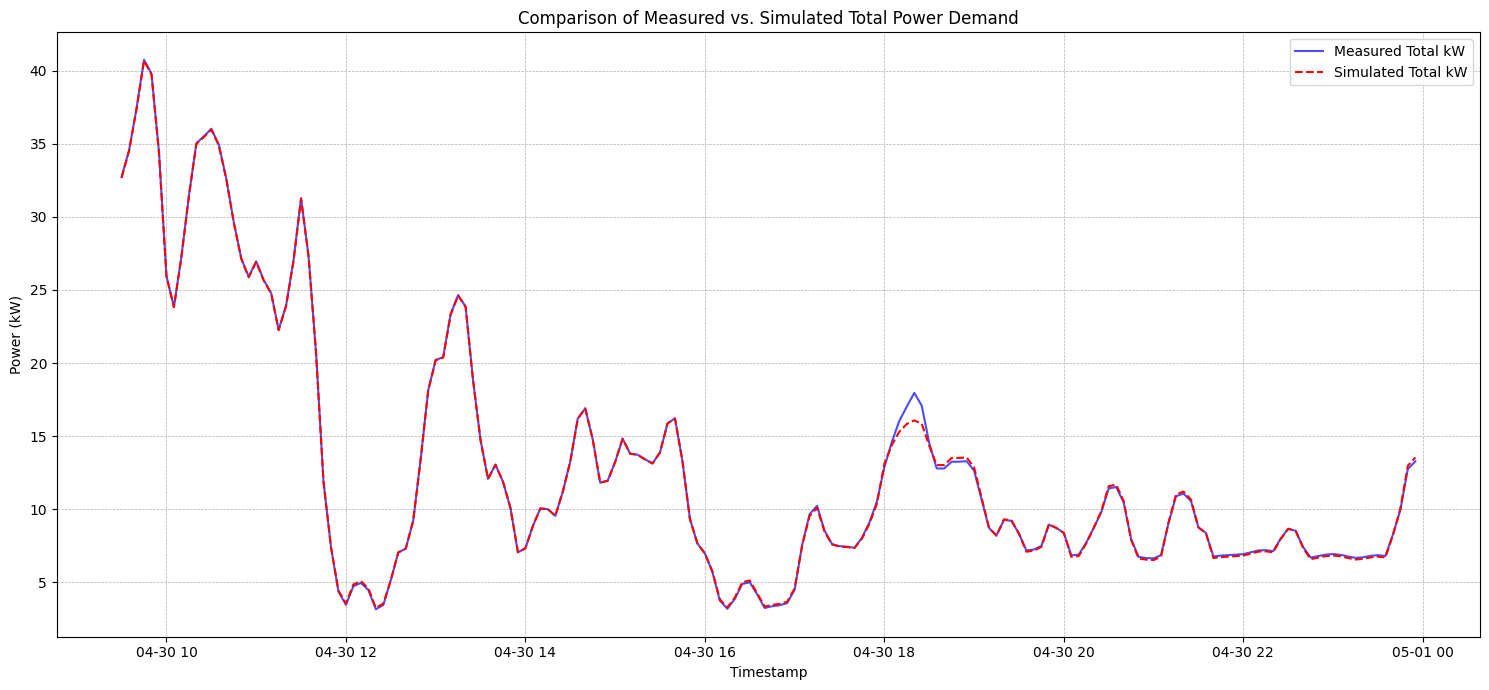


--- Next Steps ---
Consider the following if the results are unsatisfactory (review the plot first!):


In [16]:
# --- Main Execution ---
if __name__ == '__main__':
    CSV_FILE_PATH = r"C:\Users\hp\Desktop\REG108S\Project\MeasuredDataUpdated.csv" # <--- USER: REPLACE THIS WITH ACTUAL PATH
    DATA_START_TIME = '2025-04-30 09:30:00'
    DATA_END_TIME = '2025-04-30 23:55:00'
    
    DAILY_HOURS_PENALTY = 0.1

    print("--- Starting Power Profile Optimization ---")
    print(f"IMPORTANT: Please ensure LOAD_DEFINITIONS in the script are accurate for your farm, \n"
          f"especially power (kW), estimated_daily_hours, and operating windows for each load.\n"
          f"The current definitions include placeholders for 'Security_Lights_Total' and potentially 'Golf_Carts_Total'.\n")

    if not ACTIVE_LOAD_DEFINITIONS:
        print("ERROR: ACTIVE_LOAD_DEFINITIONS is empty. Please define your loads in the script.")
    else:
        try:
            measured_power, time_index, _ = load_and_prepare_data(CSV_FILE_PATH, DATA_START_TIME, DATA_END_TIME)
            
            optimized_profiles, success_flag = run_optimization(
                ACTIVE_LOAD_DEFINITIONS, 
                measured_power, 
                time_index, 
                DAILY_HOURS_PENALTY
            )
            
            # Export results and get simulated_total_power for plotting
            exported_df, simulated_total_kw_for_plot = export_results(
                optimized_profiles, 
                ACTIVE_LOAD_DEFINITIONS, 
                time_index, 
                measured_power # Pass measured_power to export_results
            )
            
            # Plot the comparison
            plot_power_comparison(time_index, measured_power, simulated_total_kw_for_plot)
            
            print("\n--- Next Steps ---")
            if not success_flag:
                print("WARNING: Optimization did not converge successfully. The results might not be optimal.")
                print("Consider the following if the results are unsatisfactory (review the plot first!):")
                # ... (rest of the advice messages remain the same)
            else:
                print("1. Review the generated CSV, MAT files, and the power comparison plot.")
                # ... (rest of the advice messages remain the same)

        except FileNotFoundError as e:
            print(f"ERROR: {e}")
        except ValueError as ve:
            print(f"ERROR: {ve}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}", exc_info=True)